# Importing

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image

from vietocr.vietocr.tool.predictor import Predictor
from vietocr.vietocr.tool.config import Cfg
from PaddleOCR import PaddleOCR, draw_ocr

# Configuration

In [4]:
# Config of PaddleOCR
detector = PaddleOCR(use_angle_cls=False, lang="vi", use_gpu=False)
# Configure of VietOCR
config = Cfg.load_config_from_name('vgg_transformer')
# config = Cfg.load_config_from_file('vietocr/config.yml')
# config['weights'] = '/Users/bmd1905/Desktop/pretrain_ocr/vi00_vi01_transformer.pth'

config['cnn']['pretrained'] = True
config['predictor']['beamsearch'] = True
config['device'] = 'mps' # mps

recognitor = Predictor(config)

[2025/05/18 19:33:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/buidokhoinguyen/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/buidokhoinguyen/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

# Ultilities

In [5]:
FONT = 'PaddleOCR/doc/fonts/latin.ttf'
def predict(recognitor, detector, img_path, save_path, padding=4, dpi=100):
    # Load image
    img = cv2.imread(img_path)

    # Text detection
    result = detector.ocr(img_path, cls=False, det=True, rec=False)
    result = result[:][:][0]

    # Filter Boxes
    boxes = []
    for line in result:
        boxes.append([[int(line[0][0]), int(line[0][1])], [int(line[2][0]), int(line[2][1])]])
    boxes = boxes[::-1]

    # Add padding to boxes
    padding = 4
    for box in boxes:
        box[0][0] = box[0][0] - padding
        box[0][1] = box[0][1] - padding
        box[1][0] = box[1][0] + padding
        box[1][1] = box[1][1] + padding

    # Text recognizion
    texts = []
    for box in boxes:
        cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        try:
            cropped_image = Image.fromarray(cropped_image)
        except:
            continue

        rec_result = recognitor.predict(cropped_image)

        text = rec_result#[0]

        texts.append(text)

    # Convert boxes to draw
    def get_rectangle_points(x1, y1, x2, y2):
        x_tl = x1
        y_tl = y2
        x_br = x2
        y_br = y1
        return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    _boxes = [get_rectangle_points(boxe[0][0], boxe[0][1], boxe[1][0], boxe[1][1]) for boxe in boxes]

    # Draw boxes and texts
    img = draw_ocr(img, _boxes, texts, scores=None, font_path=FONT)


    # Save image
    img_name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(save_path, img_name), img)
    
    txt_path = os.path.join(save_path, os.path.splitext(img_name)[0] + '.txt')
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(texts))
    print(f"Text saved to {txt_path}")

    # Display image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    height, width, depth = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray')

    plt.show()

    return boxes, texts

def display_image_in_actual_size(img_path, dpi=200):
  im_data = cv2.imread(img_path)

  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image.
  ax.imshow(im_data, cmap='gray')

  plt.show()

# Only VietOCR

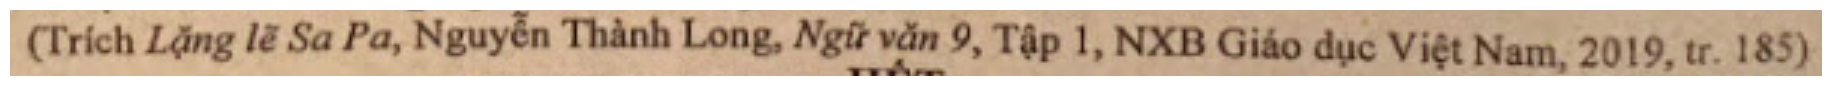

'(Trích Lặng lẽ Sa Pa, Nguyễn Thành Long, Ngữ văn 9, Tập 1, NXB Giáo dục Việt Nam, 2019, tr.185)'

In [29]:
img_path = 'samples/devan4.png'

img = cv2.imread(img_path)
img = Image.fromarray(img)
rec_result = recognitor.predict(img)

display_image_in_actual_size(img_path, dpi=100)

rec_result

# Convert PDF to Image

Saved: ./output/XNDH/XNDH_page_0.png
Processing page 1/1...
Text saved to ./output/XNDH/page_0.txt


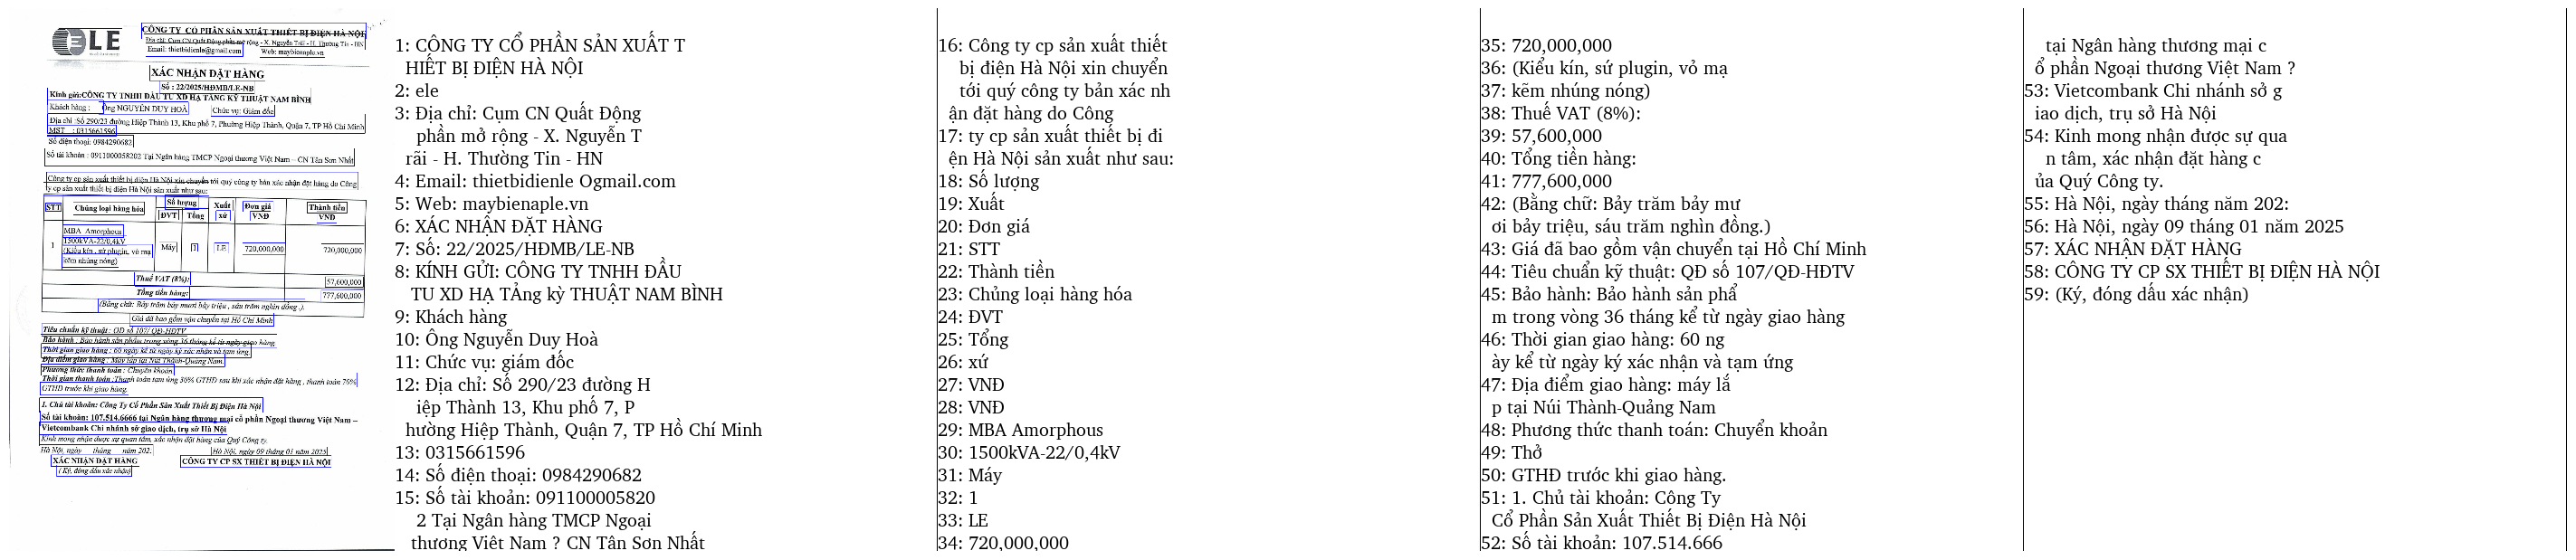

Extracted text saved to ./output/XNDH.txt


In [10]:
def convert_pdf_to_images(pdf_path, output_folder=None, dpi=300):
    try:
        # Convert PDF to list of images
        images = convert_from_path(pdf_path, dpi=dpi)
        
        # Save images if output_folder is provided
        if output_folder:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                
            # Get the PDF filename without extension
            pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
            
            # Save each page as an image
            for i, image in enumerate(images):
                image_path = os.path.join(output_folder, f"{pdf_name}_page_{i}.png")
                image.save(image_path, 'PNG')
                print(f"Saved: {image_path}")
                
        return images
    except Exception as e:
        print(f"Error converting PDF to images: {str(e)}")
        return []

def extract_text_from_pdf(pdf_path, output_folder='./output', padding=4, dpi=300):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # Convert PDF to images
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    images_folder = os.path.join(output_folder, pdf_name)
    if not os.path.exists(images_folder):
        os.makedirs(images_folder)
        
    # Convert PDF to images and save them
    images = convert_pdf_to_images(pdf_path, images_folder, dpi)
    if not images:
        return "Không thể xử lý file PDF này."
        
    # Extract text from each image
    all_text = []
    for i, image in enumerate(images):
        # Save the image to a temporary path
        img_path = os.path.join(images_folder, f"page_{i}.png")
        image.save(img_path, 'PNG')
        
        # Use the prediction function to extract text
        print(f"Processing page {i+1}/{len(images)}...")
        boxes, texts = predict(recognitor, detector, img_path, images_folder, padding=padding, dpi=100)
        if texts:
            all_text.append(f"=== PAGE {i+1} ===")
            all_text.extend(texts)
        
    # Combine all text
    extracted_text = "\n\n".join(all_text)
    
    # Save the combined text to a file
    text_path = os.path.join(output_folder, f"{pdf_name}.txt")
    with open(text_path, 'w', encoding='utf-8') as f:
        f.write(extracted_text)
    print(f"Extracted text saved to {text_path}")
    
    return extracted_text

# Example usage
# Replace with the path to your PDF file
pdf_path = "docs/XNDH.pdf"
extracted_text = extract_text_from_pdf(pdf_path, output_folder='./output', padding=2)

# Paddle + VietOCR

Text saved to ./output/devan4.txt


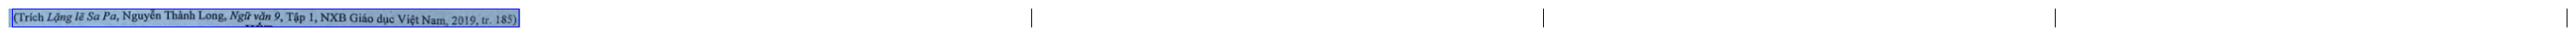

In [6]:
input_path = 'samples/devan4.png'
output_path = './output'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)

Text saved to ./output/devan2.txt


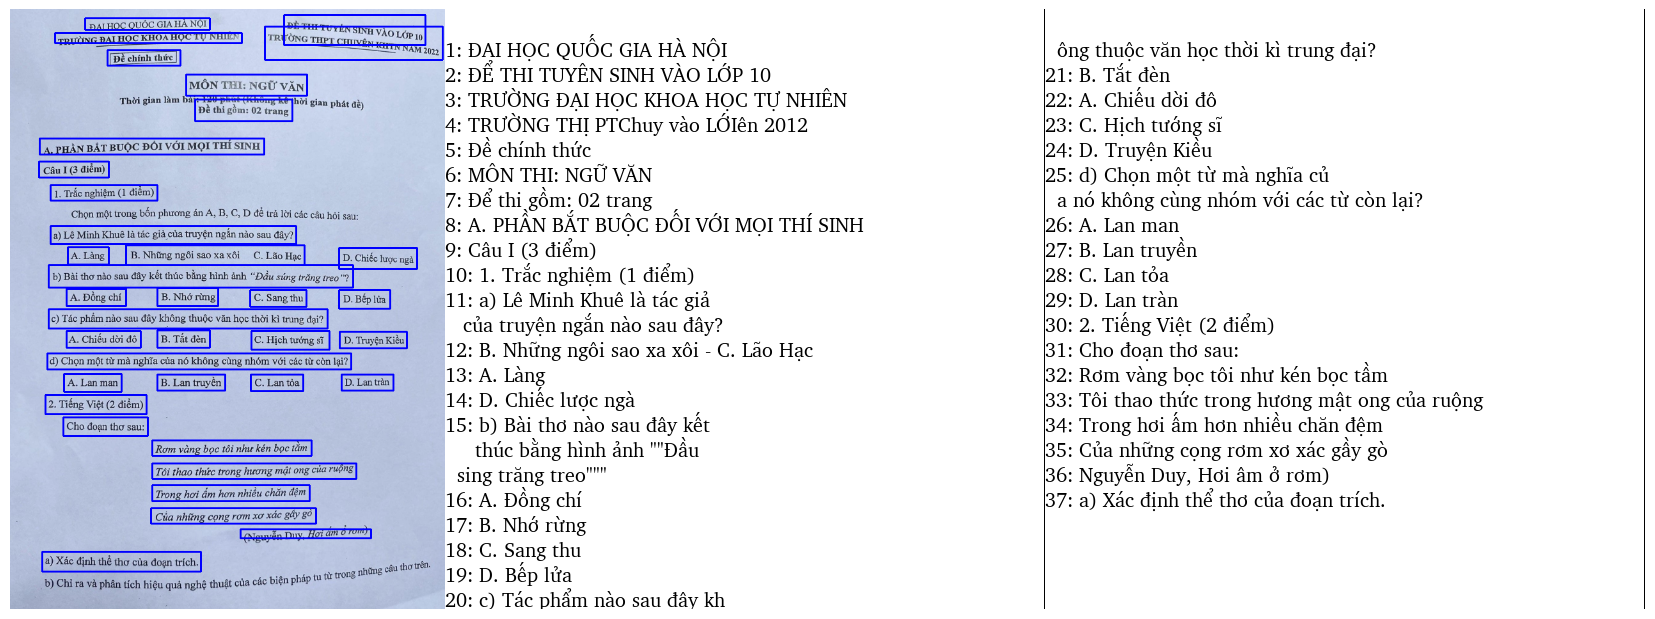

In [7]:
input_path = 'samples/devan2.jpg'
output_path = './output'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)